# Lab part 1: Errors and QPU configuration
The purpose of this exercise is to test some circuit effects related to thermal relaxation, gate fidelity and circuit depth in the context of both QPU simulators and actual hardware. The exercise is divided into 4 sections:
1. Thermal relaxation.
<br><br>
2. Single-qubit gate fidelity.
<br><br>
3. Two-qubit gate fidelity.
<br><br>
4. Accessing backend profile/metrics.

## 0. Preliminaries
Here we prepare information necessary to use our two backends — a simulated (fake) backend and an actual QPU hardware — as well as miscellaneous parameters like the number of shots. This part can be modified to suit your needs (different authentication data, connecting to a different QPU, different number of shots etc.)

In [4]:
import os
from math import pi
import numpy as np
import matplotlib.pyplot as mpl
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout
from iqm.qiskit_iqm.fake_backends import fake_adonis
from qiskit import QuantumCircuit, transpile
os.environ["IQM_TOKENS_FILE"] = r"/home/xederro/.cache/iqm-client-cli/tokens.json"

def getRealBackend(env = 'secret.env'):
    from dotenv import load_dotenv
    from iqm.qiskit_iqm.iqm_provider import IQMProvider

    load_dotenv(env)

    # os.environ["IQM_AUTH_USERNAME"] = os.getenv("IQM_AUTH_USERNAME")
    # os.environ["IQM_AUTH_PASSWORD"] = os.getenv("IQM_AUTH_PASSWORD")
    # os.environ["IQM_AUTH_SERVER"] = os.getenv("IQM_AUTH_SERVER")
    # if "IQM_TOKENS_FILE" in os.environ:
    #     os.environ.pop('IQM_TOKENS_FILE')

    iqm_url = "https://odra5.e-science.pl/station"
    provider = IQMProvider(iqm_url)

    return provider.get_backend()

simBackend = fake_adonis.IQMFakeAdonis()
realBackend = getRealBackend()

shots = 1000

station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.


## 1. Thermal relaxation
* The purpose of this exercise is to see how the length (in time) of the circuit affects the measurement.
<br><br>
* To this end, we first preapre a qubit in state $\ket{0}$ and we use a single $R_x(\pi)$ gate to obtain state $\ket{1}$.
<br><br>
* We then introduce a delay in nanoseconds in the circut using the `delay()` function.
<br><br>
* The qubit is then measured.
<br><br>
* Below is a template for constructing, transpiing and running the circuit for a number of different delays and for different backends.

In [5]:
def runEx1(delays, sim, results, shots=1000, qubit=0):
    for delay in delays:
        qc = QuantumCircuit(1, 1)
        qc.rx(pi, 0)
        qc.delay(delay, None, "ns")
        qc.measure(0, 0)
        if sim:
            backend = fake_adonis.IQMFakeAdonis()
        else:
            backend = getRealBackend()
        transpiled = transpile(qc, target=backend.restrict_to_qubits([qubit]), optimization_level=0)
        job = backend.run(transpiled, shots=shots)
        if sim:
            results.append(job.result().to_dict()['results'][0]['data']['counts']['0x1'])
        else:
            results.append(job.result().to_dict()['results'][0]['data']['counts']['1'])

Now we execute the circuits for different delay values using both a simulator and a real QPU.

In [8]:
delays = [2**i for i in range(4, 17)]
resultsSim1 = []
resultsReal1 = []

runEx1(delays, True, resultsSim1)
runEx1(delays, False, resultsReal1)

station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' i

We use the obtained data to plot the probability of measuring state $\ket{1}$ with regards to circuit length. 

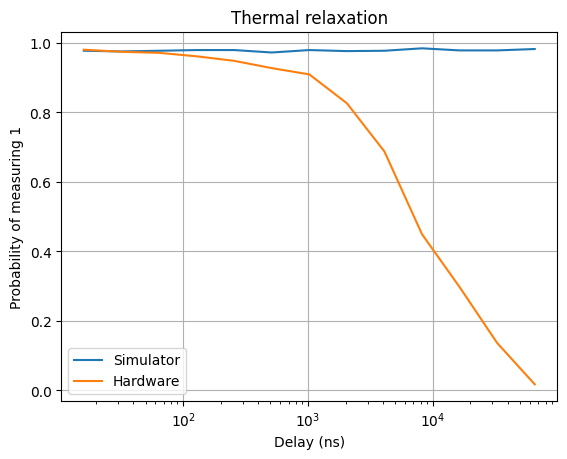

In [9]:
fig, ax = mpl.subplots()
ax.plot(delays, [x / shots for x in resultsSim1], label="Simulator")
ax.plot(delays, [x / shots for x in resultsReal1], label="Hardware")

ax.set(xlabel='Delay (ns)', ylabel='Probability of measuring 1', title='Thermal relaxation')
ax.grid()
ax.set_xscale('log')
ax.legend()
mpl.show()

## 2. Single-qubit gate fidelity
* In this exercise we will try to measure how the use of multiple gates affects measurements.
<br><br>
* We first set our qubit in state $\ket{1}$.
<br><br>
* We then apply a number of $R_x(2\pi)$ gates. As this gate peform a rotation by $360\degree$, it should not affect the measurement if $R_x$ gate fidelity is equal to 1.
<br><br>
* Below we construct an appropriate quantum circuit (note `optimization_level=0`, otherwise our rotation gate might be optimized away during transpilation).

In [10]:
def runEx2(steps, sim, results, shots=1000, qubit=0):
    for step in steps:
        qc = QuantumCircuit(1, 1)
        qc.rx(pi, 0)
        for i in range(step):
            qc.rx(2*pi, 0)
        qc.measure(0, 0)
        if sim:
            backend = fake_adonis.IQMFakeAdonis()
        else:
            backend = getRealBackend()
        transpiled = transpile(qc, target=backend.restrict_to_qubits([qubit]), optimization_level=0)
        job = backend.run(transpiled, shots=shots)
        if sim:
            results.append(job.result().to_dict()['results'][0]['data']['counts']['0x1'])
        else:
            results.append(job.result().to_dict()['results'][0]['data']['counts']['1'])

We decide on the number of "meaningless" rotations.

In [11]:
steps = [50*x for x in range(2,15)]

And run out circuit on the simulator...

In [12]:
resultsSim2 = []
runEx2(steps, True, resultsSim2)

...and on real hardware.

In [13]:
resultsReal2 = []
runEx2(steps, False, resultsReal2)

station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.
station-control-client version '9.8.0' i

We plot the results.

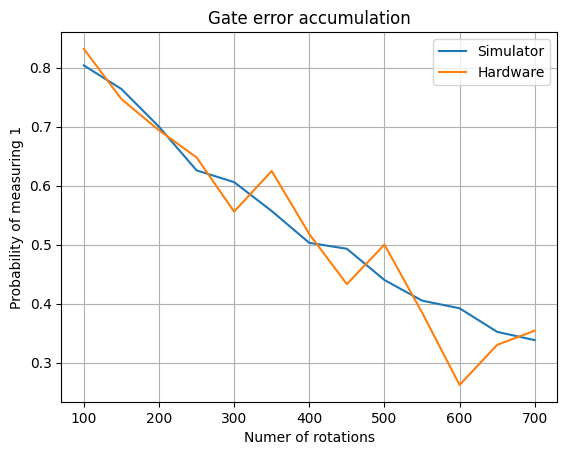

In [14]:
fig, ax = mpl.subplots()
ax.plot(steps, [x / shots for x in resultsSim2], label="Simulator")
ax.plot(steps, [x / shots for x in resultsReal2], label="Hardware")

ax.set(xlabel='Numer of rotations', ylabel='Probability of measuring 1', title='Gate error accumulation')
ax.grid()
ax.legend()
mpl.show()

## 3. Two-qubit gate fidelity
* We now perform similar reasoning for two-qubit gate.
<br><br>
* We will first prepare our system in state $\ket{01}$.
<br><br>
* We will try to use `swap` gates. If we use an even number of them, the initial state should be unnaffected.
<br><br>
* A `swap` gate can be realized with three `CX` (`CNOT`) gates, which we will implement using  a combination of `CZ` and `H` gates.
<br><br>
* The circuit template is as follows.

In [39]:
def runEx3(steps, sim, results, shots=1000):
    for step in steps:
        qc = QuantumCircuit(2)
        qc.rx(0, 0)
        qc.rx(pi/2, 1)
        qc.rx(pi/2, 1)
        for i in range(step):
            qc.h(1)
            qc.cz(0, 1)
            qc.h(0)
            qc.h(1)
            qc.cz(0, 1)
            qc.h(0)
            qc.h(1)
            qc.cz(0, 1)
            qc.h(1)
        qc.measure_active()
        if sim:
            backend = fake_adonis.IQMFakeAdonis()
        else:
            backend = getRealBackend()
        transpiled = transpile(qc, backend, optimization_level=0)
        job = backend.run(transpiled, shots=shots)
        if sim:
            results.append(job.result().to_dict()['results'][0]['data']['counts']['0x2'])
        else:
            results.append(job.result().to_dict()['results'][0]['data']['counts']['10'])

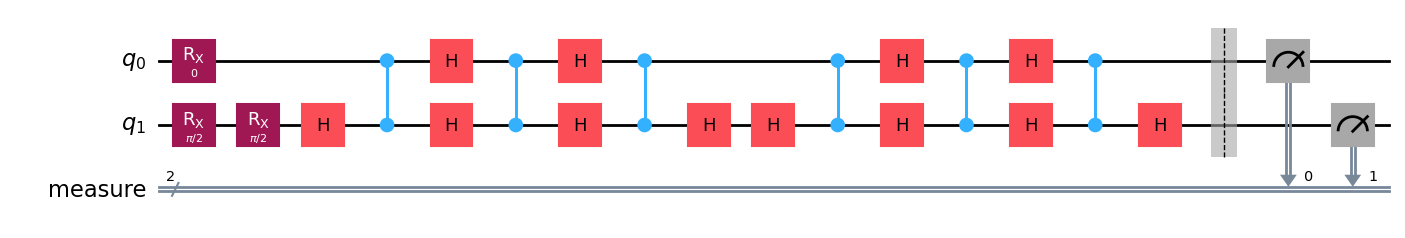

In [33]:
qc = QuantumCircuit(2)
qc.rx(0, 0)
qc.rx(pi/2, 1)
qc.rx(pi/2, 1)
for i in range(2):
    qc.h(1)
    qc.cz(0, 1)
    qc.h(0)
    qc.h(1)
    qc.cz(0, 1)
    qc.h(0)
    qc.h(1)
    qc.cz(0, 1)
    qc.h(1)
qc.measure_active()
qc.draw(output='mpl', fold=-1)

We decide on number of steps...

In [40]:
steps = [0] + [2**i for i in range(1, 12)]

...run the simulator...

In [41]:
resultsSim3 = []
runEx3(steps, True, resultsSim3, shots=10000)

...and the actual QPU.

In [42]:
resultsReal3 = []
runEx3(steps, False, resultsReal3, shots=10000)

We can now plot the results.

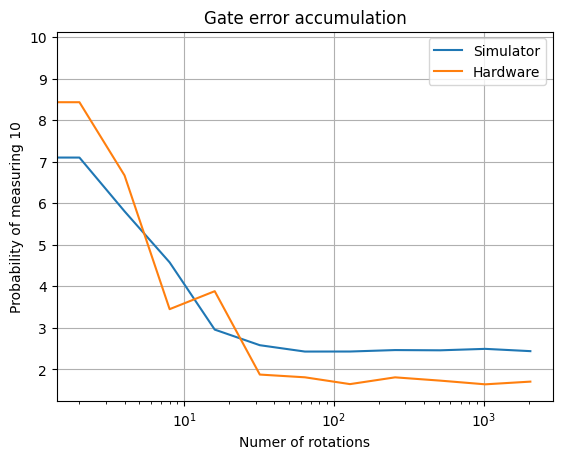

In [43]:
fig, ax = mpl.subplots()
ax.plot(steps, [x / shots for x in resultsSim3], label="Simulator")
ax.plot(steps, [x / shots for x in resultsReal3], label="Hardware")

ax.set(xlabel='Numer of rotations', ylabel='Probability of measuring 10', title='Gate error accumulation')
ax.set_xscale('log')
ax.grid()
ax.legend()
mpl.show()

## 4. Accessing backend profile/metrics.
* To utilize QPU more efficiently it may be beneficial to know the parameters — such as gate fidelity or readout errors rates — of our backend at any given time.
<br><br>
* Such parameters are also available throughout backend API, although they may indicate parameters measured during the most recent calibration etc.
<br><br>
* The method to obtain parameters is different for a simulator and a real QPU, some parameters for both backends are accessed in the example below.
<br><br>
* Parameters might be used to correct readout errors or choose the most reliable qubits (or qubit pairs) for gate operations etc.

In [20]:
profile = simBackend.error_profile

print("Readout error (0 → 1):")
for q in range(5):
    value = float(profile.readout_errors[f'QB{q+1}']['0'])
    print(f'  Q{q}: {value:.4f}')
print("Readout error (1 → 0):")
for q in range(5):
    value = float(profile.readout_errors[f'QB{q+1}']['1'])
    print(f'  Q{q}: {value:.4f}')    
print("Single-qubit gate fidelity:")
for q in range(5):
    value = float(profile.single_qubit_gate_depolarizing_error_parameters['prx'][f'QB{q+1}'])
    print(f'  Q{q}: {1-value:.4f}')
print("Two-qubit gate fidelity:")
for q in range(5):
    if q == 2:
        continue
    q2 = 2
    if q > q2:
        q, q2 = q2, q
    value = float(profile.two_qubit_gate_depolarizing_error_parameters['cz'][(f'QB{q+1}'),(f'QB{q2+1}')])
    print(f'  Q{q}-Q{q2}: {1-value:.4f}')    
print("T1 time (μs):")
for q in range(5):
    value = float(profile.t1s[f'QB{q+1}'])
    print(f'  Q{q}: {value/1000:5.2f}')
print("T2 time (μs):")
for q in range(5):
    value = float(profile.t2s[f'QB{q+1}'])
    print(f'  Q{q}: {value/1000:5.2f}')


Readout error (0 → 1):
  Q0: 0.0210
  Q1: 0.0180
  Q2: 0.0560
  Q3: 0.0210
  Q4: 0.0230
Readout error (1 → 0):
  Q0: 0.0210
  Q1: 0.0180
  Q2: 0.0560
  Q3: 0.0210
  Q4: 0.0230
Single-qubit gate fidelity:
  Q0: 0.9994
  Q1: 0.9946
  Q2: 0.9999
  Q3: 1.0000
  Q4: 0.9995
Two-qubit gate fidelity:
  Q0-Q2: 0.9665
  Q1-Q2: 0.9656
  Q2-Q3: 0.9808
  Q2-Q4: 0.9627
T1 time (μs):
  Q0: 27.00
  Q1: 33.00
  Q2: 25.00
  Q3: 40.00
  Q4: 25.00
T2 time (μs):
  Q0: 20.00
  Q1: 26.00
  Q2: 23.00
  Q3: 26.00
  Q4:  7.00


In [21]:
realBackend = getRealBackend()
metrics = realBackend.client.get_quality_metric_set().metrics

print("Readout error (0 → 1):")
for q in range(5):
    value = float(metrics[f'metrics.ssro.measure.constant.QB{q + 1}.error_0_to_1']['value'])
    uncertainty = float(metrics[f'metrics.ssro.measure.constant.QB{q + 1}.error_0_to_1']['uncertainty'])
    print(f'  Q{q}: {value:.4f} ± {uncertainty:.4f}')
print("Readout error (1 → 0):")
for q in range(5):
    value = float(metrics[f'metrics.ssro.measure.constant.QB{q + 1}.error_1_to_0']['value'])
    uncertainty = float(metrics[f'metrics.ssro.measure.constant.QB{q + 1}.error_1_to_0']['uncertainty'])
    print(f'  Q{q}: {value:.4f} ± {uncertainty:.4f}')
print("Fidelity:")
for q in range(5):
    value = float(metrics[f'metrics.ssro.measure.constant.QB{q + 1}.fidelity']['value'])
    uncertainty = float(metrics[f'metrics.ssro.measure.constant.QB{q + 1}.fidelity']['uncertainty'])
    print(f'  Q{q}: {value:.4f} ± {uncertainty:.4f}')
print("T1 time (μs):")
for q in range(5):
    value = float(metrics[f'characterization.model.QB{q+1}.t1_time']['value'])
    uncertainty = float(metrics[f'characterization.model.QB{q+1}.t1_time']['uncertainty'])
    print(f'  Q{q}: {value*1000000:5.2f} ± {uncertainty*1000000:.2f}')
print("T2 time (μs):")
for q in range(5):
    value = float(metrics[f'characterization.model.QB{q+1}.t2_time']['value'])
    uncertainty = float(metrics[f'characterization.model.QB{q+1}.t2_time']['uncertainty'])
    print(f'  Q{q}: {value*1000000:5.2f} ± {uncertainty*1000000:.2f}')
print("T2 echo time (μs):")
for q in range(5):
    value = float(metrics[f'characterization.model.QB{q+1}.t2_echo_time']['value'])
    uncertainty = float(metrics[f'characterization.model.QB{q+1}.t2_echo_time']['uncertainty'])
    print(f'  Q{q}: {value*1000000:5.2f} ± {uncertainty*1000000:.2f}')  

Readout error (0 → 1):
  Q0: 0.0000 ± 0.0000
  Q1: 0.0055 ± 0.0016
  Q2: 0.0025 ± 0.0011
  Q3: 0.0070 ± 0.0019
  Q4: 0.0015 ± 0.0009
Readout error (1 → 0):
  Q0: 0.0420 ± 0.0045
  Q1: 0.0335 ± 0.0041
  Q2: 0.0240 ± 0.0035
  Q3: 0.0415 ± 0.0045
  Q4: 0.0385 ± 0.0043
Fidelity:
  Q0: 0.9790 ± 0.0022
  Q1: 0.9805 ± 0.0022
  Q2: 0.9868 ± 0.0018
  Q3: 0.9758 ± 0.0024
  Q4: 0.9800 ± 0.0022
T1 time (μs):
  Q0: 18.50 ± 1.03
  Q1: 22.87 ± 2.45
  Q2: 20.75 ± 1.21
  Q3: 21.91 ± 2.03
  Q4: 18.09 ± 0.85
T2 time (μs):
  Q0: 11.14 ± 0.78
  Q1: 13.07 ± 0.89
  Q2:  9.32 ± 0.71
  Q3: 11.37 ± 1.19
  Q4: 11.52 ± 0.73
T2 echo time (μs):
  Q0: 12.28 ± 1.16
  Q1: 22.49 ± 2.23
  Q2: 16.98 ± 1.55
  Q3: 12.92 ± 1.47
  Q4: 12.63 ± 1.60
